In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
cap = cv2.VideoCapture('project_video.mp4')
count = 0
ret = True
while ret:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("project_video_export/frame%d.jpg" % count, frame)     # save frame as JPEG file
    count +=1

    # Display the resulting frame
    # cv2.imshow('frame',gray)
#     if cv2.waitKey(10):
#         break

In [2]:
class LaneDetection(object):
    
    def __init__(self, cal_images, test_image):
        self.cal_images = cal_images
        self.calibrate_camera(cv2.imread(test_image))
    
    def set_obj_and_img_points(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
    
        # Step through the list and search for chessboard corners
        for fname in self.cal_images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
#             if not ret: print(fname)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    def calibrate_camera(self, test_image):
        img_size = (test_image.shape[1], test_image.shape[0])
        
        self.set_obj_and_img_points()
        
        if len(self.objpoints) == 0 or len(self.imgpoints) == 0:
            raise Exception("Calibration Failed!")
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def to_gray(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    def abs_sobel_thresh(self, gray, orient='x', thresh_min=40, thresh_max=200, ksize=5):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
        
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output
    
    def mag_thresh(self, gray, thresh_min=40, thresh_max=250, ksize=7):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Rescale to 8 bit
        scale_factor = np.max(gradmag) / 255 
        
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        
        binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

        # Return the binary image
        return binary_output
    
    def dir_threshold(self, gray, ksize=7, thresh=(0.7, 1.3)):

        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
        binary_output =  np.zeros_like(absgraddir)
        
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def gradient_binary(self, gray, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3)):
        # Apply each of the thresholding functions
        gradx = self.abs_sobel_thresh(gray, orient='x',thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         grady = self.abs_sobel_thresh(gray, orient='y', thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         mag_binary = self.mag_thresh(gray, thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         dir_binary = self.dir_threshold(gray, ksize=ksize, thresh=thresh)
        
#         combined = np.zeros_like(dir_binary)
        
#         combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        # Return the result
        return gradx
        
    def binary_transform(self, img, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3), hls_thresh=(175, 255)):
        
        gray = self.to_gray(img)
        
        # Threshold gradient
        sxbinary = self.gradient_binary(gray)
    
#         # Threshold color channel
#         s_binary = self.to_hls(img)
    
#         # Stack each channel to view their individual contributions in green and blue respectively
#         # This returns a stack of the two binary images, whose components you can see as different colors
#         color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
#         # Combine the two binary thresholds
#         combined_binary = np.zeros_like(sxbinary)
#         combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        # Return the result
        return sxbinary
    
    def to_hls(self, img, hls_thresh=(50, 200)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        
        s_channel = hls[:,:,2]
        
        binary_output = np.zeros_like(s_channel)
        
        binary_output[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
        
        return binary_output
    
    def perspective_transform(self, binary):
        img_size = (binary.shape[1], binary.shape[0])

        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        return cv2.warpPerspective(binary, M, img_size)
    
    def detect_lines_first_frame(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)

        leftx_base = np.argmax(histogram[:midpoint])

        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            
            win_y_high = binary_warped.shape[0] - window * window_height
            
            win_xleft_low = leftx_current - margin
            
            win_xleft_high = leftx_current + margin
            
            win_xright_low = rightx_current - margin
            
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),(win_xleft_high, win_y_high), (0, 255, 0), 2) 
            
            cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high, win_y_high), (0, 255, 0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
            
        right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
            
        lefty = nonzeroy[left_lane_inds] 
            
        rightx = nonzerox[right_lane_inds]
            
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
            
        self.right_fit = np.polyfit(righty, rightx, 2)
            
        # This is ONLY for plotting
        # Generate x and y values for plotting
#         ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#         left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
#         right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

#         out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#         out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
        
    def detect_lines(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = self.left_fit[0] * ploty**2 + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = self.right_fit[0] * ploty**2 + self.right_fit[1] * ploty + self.right_fit[2]

         # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        y_eval = np.max(ploty)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
    
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
#         print(left_curverad*3.28084, 'ft', right_curverad*3.28084, 'ft')
#         print(left_curverad, 'm', right_curverad, 'm')
#         Example values: 632.1 m    626.2 m

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
test_image = images.pop(-1)
ld = LaneDetection(images, test_image)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:183: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


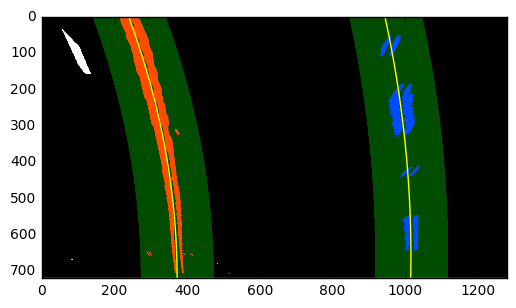

In [4]:
img = cv2.imread('project_video_export/frame0.jpg')
binary = ld.binary_transform(ld.undistort(img))
binary_warped = ld.perspective_transform(binary)
ld.detect_lines_first_frame(binary_warped)
img = cv2.imread('project_video_export/frame1.jpg')
binary = ld.binary_transform(img)
binary_warped = ld.perspective_transform(binary)
ld.detect_lines(binary_warped)

In [ ]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image